<a href="https://colab.research.google.com/github/delemarchand2020/IVADO_MILA_DL/blob/main/Predict_FX_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet d'utilisation des modèles RNN, TSTM et Transformer pour la prédiction des taux de change et comparaison avec le modèle de marche aléatoire

Pour les besoins de ce projet, on récupère les historiques journaliers des taux de change des 10 principales devises depuis 1980, on bâtit des séquences de n jours consécutifs dont la cible à prédire est le n+1 ieme jour. On utilise une technique de "bootstrap" pour faire des prédictions, par la suite, sur plusieurs jours : à partir d'une séquence initiale de n jours, on prévoit le n+1 iéme jour avec RNN puis on soumet au RNN une nouvelle séquence de n jours incluant la dernière prévision effectuée (et en ôtant le premier terme de la séquence précédente) et de proche en proche on effectue des prévisions sur 2, 3, ... x jours.

Le RNN (au sens large, c'est à dire un RNN pur ou un LSTM ou encore un Transformer) est alimenté en apprentissage avec de telles séquences sur N devises et du point de vue du RNN, on suppose que ces devises suivent le même processus. Dès lors, on pourra effectuer des prévisions sur n'importe quelle série chronologique suivant ce même processus.

Pour comparer nos prévisions et évaluer la performance de prévision du RNN, on considére les 2 modèles de références suivants: 


>(1) "random walk" : la prévision du n+1 ième jour est le taux de change observé le n ième jour (c'est le modèle de marche aléatoire). Ce modèle dit que la meilleure prévision du taux de change dans le futur (1, 2, ... ou x jours) est le taux de change qui prévaut aujourd'hui. En d'autres termes, le meilleur estimateur du taux futur est le taux comptant prévalant.

>(2) moyenne mobile : la prévision du n+1 ième jour est la moyenne des taux des n derniers jours. 

Ces 2 modèles ne requierent aucune autre information contextuelle.

Le Mean-Squared-Error, écart entre la valeur réellement observée et la prévision des différents modèles ("random walk", moyenne mobile, RNN), donnera une bonne indication de la performance relative des modèles étudiés.

Dans la littérature en finance internationale, il est connu que le modèle de marche aléatoire (modèle 1) est très difficile à battre. 

Est-ce que le RNN aura de la difficulté à le battre également ? C'est la question à laquelle ce projet tente de répondre.

**Notes :**

>(a) quelques portions de code ont été copié des tutoriaux du MILA (cours IVADO/MILA DeepLearning 2021).
Voir les sources [ici](https://github.com/mila-iqia/ivado-mila-dl-school-2021/tree/main/tutorials).

>(b) références des articles IA/DL: 
- https://www.researchgate.net/publication/315415407_Deep_networks_for_predicting_direction_of_change_in_foreign_exchange_rates
- https://towardsdatascience.com/stock-prediction-using-recurrent-neural-networks-c03637437578
- https://pub.towardsai.net/bitcoin-price-prediction-with-rnn-and-lstm-in-python-f912d57c483e

>(c) références des articles de finance:
- [Meese & Rogoff (1983)](http://lien.uqam.ca/YjOACsY)
- [Rossi (2013)](http://lien.uqam.ca/fXxa052)
- [Engel, Mark & West (2012)](http://www.nber.org/papers/w18382.pdf)

# Initialisation

In [84]:
!pip3 install torch

In [85]:
import torch

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.8.1+cu101
GPU Available: True


In [86]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

In [87]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [88]:
import copy
import gc
import math
import time
import os

import unittest

# Import et préparation des données

## Chargement du fichier et nettoyage des données


mean=2.518004180718107
std=2.6185094980106736


,USDCAD,EURUSD,GBPUSD,USDJPY,USDCHF,AUDUSD,USDSEK,USDNOK,NZDUSD
count,10596.000000,10596.000000,10596.000000,10596.000000,10596.000000,10596.000000,10596.000000,10596.000000,10596.000000
mean,1.264218,1.172420,1.611962,1.310168,1.374366,0.786031,7.446277,7.043842,0.652753
std,0.150479,0.175264,0.228563,0.455981,0.396077,0.146864,1.305758,1.130249,0.119710
min,0.920350,0.644370,1.052000,0.758240,0.720880,0.478950,4.106000,4.793000,0.391450
25%,1.163500,1.082043,1.474000,1.058257,1.005525,0.698897,6.515923,6.184220,0.567100
50%,1.270555,1.182050,1.589665,1.158975,1.313500,0.759700,7.419900,6.868375,0.656500
75%,1.365112,1.297970,1.722000,1.336300,1.570475,0.868263,8.324337,7.833502,0.720965
max,1.613500,1.599130,2.446000,2.776500,2.924500,1.189000,11.026000,11.705130,0.992700


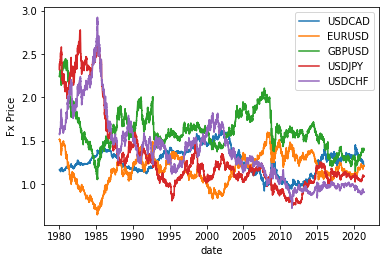

In [89]:
url_data_source = 'https://github.com/delemarchand2020/IVADO_MILA_DL/raw/main/FX_HFData.xlsx'
df = pd.read_excel(url_data_source, sheet_name='Daily All',
                   dtype={' ': datetime.date, 'USDCAD Curncy': float, 
                          'EURUSD Curncy': float, 'GBPUSD Curncy': float,
                          'USDJPY Curncy':float, 'USDCHF Curncy':float,
                          'AUDUSD Curncy':float,'USDSEK Curncy':float,
                          'USDNOK Curncy':float,'NZDUSD Curncy':float, 
                          'USDSGD Curncy':float })
df = df.drop(columns=['USDSGD Curncy'])
df = df.dropna()
df.columns = ['date','USDCAD','EURUSD', 'GBPUSD','USDJPY','USDCHF','AUDUSD','USDSEK',
              'USDNOK','NZDUSD']

df['USDJPY'] = df['USDJPY']/100

plt.figure()
plt.plot(df['date'],df['USDCAD'], label='USDCAD')
plt.plot(df['date'],df['EURUSD'], label='EURUSD')
plt.plot(df['date'],df['GBPUSD'], label='GBPUSD')
plt.plot(df['date'],df['USDJPY'], label='USDJPY')
plt.plot(df['date'],df['USDCHF'], label='USDCHF')
plt.xlabel('date')
plt.ylabel('Fx Price')
plt.legend()

df = df.drop(columns=['date'])

all_mean = df.stack().mean()
all_std = df.stack().std()

print(f"mean={all_mean}")
print(f"std={all_std}")

df.describe()

## Création des datasets (train, validate et test)

On divise le dataset en 3 parties:

<ol>
<li> <b> Train</b> (60% du dataset): utilisé pour entraîner le modèle. </li>   
<li> <b> Validation</b> (20% du dataset): utilisé pour évaluer les "hyper-parameters", c'est à dire les paramètres intrinsèques au bon apprentissage. </li>   
<li> <b> Test</b> (20% du dataset): utilisé pour évaluer la généralisation de la performance sur des données hors apprentissage. </li>
</ol>

On créé les jeux de données d'entrées et de sorties telles que les *pos_x* premiers prix journaliers de la séquence sont les données d'entrée (X) et le *pos_y* ieme de la séquence est la cible (Y) à prédire !

Puis, on "standardise" les jeux de données pour faciliter l'apprentissage RNN.

### Fonction split_x_y_in_torch

In [90]:
def split_x_y_in_torch(dfs,seq_len, pos_x=7, pos_y=8):
    X = []
    Y = []
    for row in dfs:
      X.append([row[0:pos_x]])
      Y.append([row[pos_y-1]])
    X = np.array(X)
    Y = np.array(Y)
    return torch.from_numpy(X.transpose(0,2,1)).float(), torch.from_numpy(Y).float()

#### Tests unitaires

In [91]:
class SplitTestCase(unittest.TestCase):

    def setUp(self):
        """Call before every test case."""
        s1 = pd.Series([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7])
        s2 = pd.Series([8.1, 9.2, 10.3, 11.4, 12.5, 13.6, 14.7])
        self.seq_len = 7
        self.dfs = []
        self.dfs.append(s1)
        self.dfs.append(s2)
        self.split_x_y_in_torch = split_x_y_in_torch

    def tearDown(self):
        """Call after every test case."""

    def testTailleDfs(self):
        """note that all test method names must begin with 'test.'"""
        assert  len(self.dfs) == 2, "La taille du dataframe n'est pas la bonne !"

    def testSplit3_7(self):
        result1, result2 = self.split_x_y_in_torch(self.dfs,self.seq_len, pos_x=3, pos_y=7)
        expected1 = torch.from_numpy(np.array([[[1.1], [2.2], [3.3]], [[8.1], [9.2], [10.3]]])).float()
        expected2 = torch.from_numpy(np.array([[7.7], [14.7]])).float()
        assert result1.shape == torch.Size([2, 3, 1]), "taille tensor incorrecte"
        assert torch.equal(result1, expected1) == True, "split de base echoue"
        assert torch.equal(result2, expected2) == True, "split de base echoue"

    def testSplit3_4(self):
        result1, result2 = self.split_x_y_in_torch(self.dfs,self.seq_len, pos_x=3, pos_y=4)
        expected1 = torch.from_numpy(np.array([[[1.1], [2.2], [3.3]], [[8.1], [9.2], [10.3]]])).float()
        expected2 = torch.from_numpy(np.array([[4.4], [11.4]])).float()
        assert torch.equal(result1, expected1) == True, "split de base echoue"
        assert torch.equal(result2, expected2) == True, "split de base echoue"

### Fonction standardize

In [92]:
def standardize(X, mean=None, std=None):
    """The function standardizes the X tensor. 
    Args:
      X: torch.Tensor.
    
    Returns:
      Xs: torch.Tensor standardize.
      mean: float, the mean of X.
      stdev: float, the stdev of X.
    """
    
    X=X.float()

    if mean == None:
      mean = torch.mean(X)
    if std == None:
      std = torch.std(X)
      
    Xs = (X-mean) / std

    return Xs, mean, std

#### Tests unitaires 

In [93]:
class StandardizeTestCase(unittest.TestCase):

    def setUp(self):
        """Call before every test case."""
        s1 = pd.Series([1.0, 2.0, 3.0, 4.4, 5.5, 6.6, 7.0])
        s2 = pd.Series([8.0, 9.0, 10.0, 11.4, 12.5, 13.6, 14.0])
        dfs = []
        dfs.append(s1)
        dfs.append(s2)
        
        self.x, self.y = split_x_y_in_torch(dfs,seq_len=7, pos_x=3, pos_y=7)
        self.standardize = standardize

    def tearDown(self):
        """Call after every test case."""

    def testCalculStat(self):
        """note that all test method names must begin with 'test.'"""
        xs, m, s = self.standardize(self.x)
        assert  m == 5.5
        assert  np.round(s,3) == 3.937

    def testIdentite(self):
        xs, m, s = self.standardize(self.x, 0, 1)
        expected_xs = torch.from_numpy(np.array([[[1.0], [2.0], [3.0]], [[8.0], [9.0], [10.0]]])).float()
        assert  m == 0
        assert  s == 1
        assert torch.equal(xs, expected_xs) == True

    def testStandardisationX(self):
        xs, m, s = self.standardize(self.x, 1, 2)
        expected_xs = torch.from_numpy(np.array([[[0.0], [0.5], [1.0]], [[3.5], [4.0], [4.5]]])).float()
        assert torch.equal(xs, expected_xs) == True

    def testStandardisationY(self):
        ys, m, s = self.standardize(self.y, 1, 1)
        expected_ys = torch.from_numpy(np.array(np.array([[6.0], [13.0]]))).float()
        assert torch.equal(ys, expected_ys) == True

### Fonction create_datasets

In [94]:
def create_datasets(seq_len=8, name_serie='USDCAD', pos_x=7, pos_y=8, mean=None, std=None):
    s = pd.Series(df[name_serie].values) # USDCAD ou EURUSD ou GBPUSD

    arr = [s.shift(x).values[::-1][:seq_len] for x in range(len(s))[::-1]]
    dfs = []
    for row in arr:
      dfs.append(row[::-1])
    dfs = dfs[seq_len-1:]

    train, validate, test = np.split(dfs, [int(.6*len(dfs)), int(.8*len(dfs))])

    X_train, y_train = split_x_y_in_torch(train, seq_len, pos_x, pos_y)
    X_validate, y_validate = split_x_y_in_torch(validate, seq_len, pos_x, pos_y)
    X_test, y_test = split_x_y_in_torch(test, seq_len, pos_x, pos_y)

    if mean == None:
        mean = np.mean(dfs)
    if std == None:
        std = np.std(dfs)

    Xs_train, Xs_train_mean, Xs_train_std = standardize(X_train, mean, std)
    ys_train, ys_train_mean, ys_train_std = standardize(y_train, mean, std)

    Xs_validate, Xs_validate_mean, Xs_validate_std = standardize(X_validate, mean, std)
    ys_validate, ys_validate_mean, ys_validate_std = standardize(y_validate, mean, std)

    Xs_test, Xs_test_mean, Xs_test_std = standardize(X_test, mean, std)
    ys_test, ys_test_mean, ys_test_std = standardize(y_test, mean, std)

    return [Xs_train,ys_train], [Xs_validate,ys_validate], [Xs_test,ys_test], [mean, std]

#### Tests unitaires

In [95]:
class CreateDatasetsTestCase(unittest.TestCase):

    def setUp(self):
        self.data_train, self.data_val, self.data_test, self.stat = create_datasets(seq_len=15, 
                                                            name_serie='USDCAD',
                                                            pos_x=8,
                                                            pos_y=13)

        _, _, _, self.stat_all = create_datasets(seq_len=15, 
                                                            name_serie='USDCAD',
                                                            pos_x=8,
                                                            pos_y=13,
                                                            mean=0, std=1)
    def testCalculStat(self):
        m, s = self.stat[0], self.stat[1]
        assert  np.round(s,2) == 0.15
        assert  np.round(m,2) == 1.26
    
    def testCalculStatFixed(self):
        m, s = self.stat_all[0], self.stat_all[1]
        assert  np.round(s,2) == 1
        assert  np.round(m,2) == 0

    def testRepartitionDatasets(self):
        x_train = self.data_train[0]
        y_test = self.data_test[1]
        len_x_train_expected = 6349 #arrondi sup de (10596 - 15)*0.6 = 6349
        len_y_test_expected = 2117
        assert len(x_train) == len_x_train_expected
        assert len(y_test) ==  len_y_test_expected

    def testTailleXY(self):
        x_val = self.data_val[0]
        y_val = self.data_val[1]
        assert x_val.shape[1] == 8
        assert y_val.shape[1] == 1

    def testPositionY(self):
        x_val = self.data_val[0]
        y_val = self.data_val[1]
        n = np.random.randint(low=6, high=100)
        assert x_val[n][-1] == y_val[n-5]

# Implémentation des modèles RNN, LSTM, Transformer

## Modèle RNN
Implementation d'un modèle RNN en utilisant [torch.nn.RNN()](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) class. Les paramètres en entrée sont:
- **input_dim**: la dimension des données en entrée (dans notre cas, ce sera un scalaire donc input_dim = 1)
- **output_dim**: la dimension des données en sortie (nous voulons une prédiction qui est aussi un scalaire, donc output_dim = 1)
- **hidden_size**: la taille des couches internes du RNN. C'est un paramètre à "fine tuner".
- **n_layers**: le nombre de couche du RNN. C'est également un paramètre à "fine tuner".

### Définition du modèle RNN

>**Note:** extrait des tutoriaux du MILA

In [96]:
class RNNLinear(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, n_layers, debug_flag=False):
        super(RNNLinear, self).__init__()
        self.rnn_layer = torch.nn.RNN(input_size=input_dim,hidden_size=hidden_size,num_layers=n_layers)
        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)
        self.print_debug_flag = debug_flag

    def print_debug(self,text,var):
      if self.print_debug_flag == True:
        print(text,var)

    def forward(self, x):
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # The RNN's input must be of size (seq_len, batch_size, input_dim)
        self.print_debug('x:',x)

        x = torch.transpose(x, 0, 1)

        self.print_debug('x\':',x)

        output, hidden = self.rnn_layer(x) #hidden c'est le dernier h (vecteur)
                                            # si on veut initialiser un autre rnn avec les parametres déjà appris

        self.print_debug('hidden:',hidden)
        self.print_debug('output:',output)
        self.print_debug('output[-1]:',output[-1])
        self.print_debug('linear_layer(output):',self.linear_layer(output))
        self.print_debug('linear_layer(output[-1]):',self.linear_layer(output[-1]))

        output = output[-1]
        pred = self.linear_layer(output)
        
        self.print_debug('pred:',pred)

        return pred

### Instanciation du modèle

>**Note:** extrait des tutoriaux du MILA

> **ATTENTION** : si l'on souhaite faire du pre-tranining avec plusieurs devises, pensez à mettre *rnn_weights =  previous_rnn_weights*, sinon le RNN partira avec des poids initiaux aléatoires.

In [97]:
def get_rnn_instance(input_dim = 1,output_dim = 1,n_layers = 2,hidden_size = 20):
    # Declaration of the RNN model
    model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers)

    # Transfer the model to the proper device
    model_rnn = model_rnn.to(device)

    # save its initial weights (we do this so that, if we run the model
    # multiple time, we always start from these randomly initialized weights)
    init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

    return model_rnn, init_rnn_weights

## Modèle LSTM
Implementation d'un modèle LSTM en utilisant [torch.nn.LSTM()](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) class. Les paramètres en entrée sont:
- **input_dim**: la dimension des données en entrée (dans notre cas, ce sera un scalaire donc input_dim = 1)
- **output_dim**: la dimension des données en sortie (nous voulons une prédiction qui est aussi un scalaire, donc output_dim = 1)
- **hidden_size**: la taille des couches internes du RNN. C'est un paramètre à "fine tuner".
- **n_layers**: le nombre de couche du RNN. C'est également un paramètre à "fine tuner".

### Définition du modèle LSTM

>**Note:** extrait des tutoriaux du MILA

In [98]:
class LSTMLinear(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(LSTMLinear, self).__init__()
        self.lstm_layer = torch.nn.LSTM(input_size=input_dim,hidden_size=hidden_size,num_layers=n_layers)
        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)

    def forward(self, x):
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # The LSTM's input must be of size (seq_len, batch_size, input_dim)
        x = torch.transpose(x, 0, 1)
        output, (hidden, cn) = self.lstm_layer(x) # hidden et cn pour usage ultérieur (derniere cellule: h et c)
        
        output = output[-1]

        pred = self.linear_layer(output)

        return pred

### Instanciation du modèle

>**Note:** extrait des tutoriaux du MILA

> **ATTENTION** : si l'on souhaite faire du pre-tranining avec plusieurs devises, pensez à mettre *rnn_weights =  previous_rnn_weights*, sinon le RNN partira avec des poids initiaux aléatoires.

In [99]:
def get_lstm_instance(input_dim = 1,output_dim = 1,n_layers = 2,hidden_size = 20):
    # Declaration of the RNN model
    model_lstm = LSTMLinear(input_dim, output_dim, hidden_size, n_layers)

    # Transfer the model to the proper device
    model_lstm = model_lstm.to(device)

    # save its initial weights (we do this so that, if we run the model
    # multiple time, we always start from these randomly initialized weights)
    init_rnn_weights = copy.deepcopy(model_lstm.state_dict())

    return model_lstm, init_rnn_weights

## Modèle Transformer
Implementation d'un modèle Transformer en utilisant les classes [torch.nn.TransformerEncoderLayer()](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html) et [torch.nn.TransformerEncoder()](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html) classes. Les paramètres en entrée sont:
- **input_dim**: la dimension des données en entrée (dans notre cas, ce sera un scalaire donc input_dim = 1)
- **output_dim**: la dimension des données en sortie (nous voulons une prédiction qui est aussi un scalaire, donc output_dim = 1)
- **hidden_size**: la taille des couches internes du RNN. C'est un paramètre à "fine tuner".
- **n_heads**: le nombre de "têtes d'attention" dans chaque couche "Transformer encoder". C'est également un paramètre à "fine tuner".
- **n_layers**: le nombre de couche du RNN. C'est également un paramètre à "fine tuner".

### Définition du modèle Transformer

>**Note:** extrait des tutoriaux du MILA

In [100]:
######################################################################
# ``PositionalEncoding`` module injects some information about the
# relative or absolute position of the tokens in the sequence. The
# positional encodings have the same dimension as the embeddings so that
# the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
# different frequencies.
#
# Source : https://pytorch.org/tutorials/beginner/transformer_tutorial.html
#
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [101]:
class TransformerLinear(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, n_heads, n_layers):
        super(TransformerLinear, self).__init__()

        self.linear_inp_to_hid = nn.Linear(input_dim, hidden_size)
        #self.pos_encoder = PositionalEncoding(input_dim)
        self.pos_encoder = PositionalEncoding(hidden_size)

        # ma partie
        trans_encoder_layer = torch.nn.TransformerEncoderLayer(d_model=hidden_size, nhead=n_heads)
        self.trans_layer = torch.nn.TransformerEncoder(encoder_layer=trans_encoder_layer, num_layers=n_layers)

        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)

    def forward(self, x):
        # Project input and inject positional encodings
        x = self.linear_inp_to_hid(x)
        x = self.pos_encoder(x)

        # Invoke transformer and produce prediction
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # Note: the input to the Transformer must be of size (seq_len, batch_size, hidden_size)
        x = torch.transpose(x, 0, 1)
        output = self.trans_layer(x)

        output = output[0]
        pred = self.linear_layer(output)
        
        return pred

### Instanciation du modèle

>**Note:** extrait des tutoriaux du MILA

> **ATTENTION** : si l'on souhaite faire du pre-tranining avec plusieurs devises, pensez à mettre *rnn_weights =  previous_rnn_weights*, sinon le RNN partira avec des poids initiaux aléatoires.

In [102]:
def get_transformer_instance(input_dim = 1,output_dim = 1,n_layers = 2,hidden_size = 20, n_heads=1):
    # Declaration of the Transformer model
    model_transformer = TransformerLinear(input_dim, output_dim, hidden_size, n_heads, n_layers)

    # Transfer the model to the proper device
    model_transformer = model_transformer.to(device)

    # save its initial weights (we do this so that, if we run the model
    # multiple time, we always start from these randomly initialized weights)
    init_transformer_weights = copy.deepcopy(model_transformer.state_dict())

    return model_transformer, init_transformer_weights

## Création des "data loader"
Cela utilise les objets DataLoader PyTorch pour manipuler plus facilement et efficacement nos données.
>**Note:** extrait des tutoriaux du MILA

In [103]:
def create_dataloader(Xs_train, ys_train,Xs_validate, ys_validate,Xs_test, ys_test,batch_size = 4):
    
    # dataloader for the training dataset
    train_loader = DataLoader(TensorDataset(Xs_train, ys_train), batch_size, shuffle=True)

    # prepare the dataloader for the validation dataset
    valid_loader = DataLoader(TensorDataset(Xs_validate, ys_validate), batch_size)

    # prepare the dataloader for the test dataset
    test_loader = DataLoader(TensorDataset(Xs_test, ys_test), batch_size)

    return train_loader, valid_loader, test_loader

## Boucle d'apprentissage



>**Note:** extrait des tutoriaux du MILA



### Définition de la boucle d'apprentissage

In [104]:
# Define function to encapsulate main training loop
def train_model(model, init_weights, optimizer, loss_fun, n_epoch = 25, debug_flag=False):

    since = time.time()

    train_loss_history = []
    valid_loss_history = []

    model.load_state_dict(init_weights)

    print("Start training")

    for epoch in range(n_epoch):
        
        train_loss = 0
        train_n_iter = 0
        
        # Set model to train mode
        model.train()
        torch.set_grad_enabled(True)
        
        # Iterate over train data
        for x, y in train_loader:  

            
            # Put tensors on device (GPU when available)
            x = x.to(device)
            y = y.to(device)

            # Zero the gradient buffer
            optimizer.zero_grad()
            
            # Perform the Forward operation
            outputs = model(x)
            
            # Calculate the loss using the loss function
            loss = loss_fun(outputs, y)
            
            # Perform the Backward operation
            loss.backward()
            
            # Perform the Optimization step
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            train_n_iter += 1
        
        valid_loss = 0
        valid_n_iter = 0
        
        # Set model to evaluate mode
        model.eval()
        with torch.no_grad():
        
            # Iterate over valid data
            for x, y in valid_loader:  
            
                # Put tensors on device (GPU when available)
                x = x.to(device)
                y = y.to(device)
            
                # Perform the Forward operation
                outputs = model(x)
                
                # Calculate the loss using the loss fun function
                loss = loss_fun(outputs,y)
            
                # Statistics
                valid_loss += loss.item()
                valid_n_iter += 1
        
        train_loss_history.append(train_loss / train_n_iter)
        valid_loss_history.append(valid_loss / valid_n_iter)

        if debug_flag == True:
            print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
                  .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return train_loss_history, valid_loss_history

### Lancement des tests unitaires des fonctions de création des datasets

In [105]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

............
----------------------------------------------------------------------
Ran 12 tests in 13.453s

OK


### Lancement de l'apprentissage

C'est dans la portion suivante qu'on lance un apprentissage initial sur une première devise suivi des autres en cascadant un pre-training consécutif (on conserve les poids précédement calculés).

*Voir le commentaire # pre-training dans le code d'instanciation du modèle RNN.*

In [106]:
learning_rate = 0.01
# Define the Optimizer
def get_optimizer(model, learning_rate=learning_rate):
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      return optimizer

> Pour des raisons de facilité, on garde les variables model_rnn, rnn_weights que ce soit un modèle RNN pur ou LSTM (qui est un type de RNN en fait) ou encore Transformer

Start training
Training complete in 1m 17s


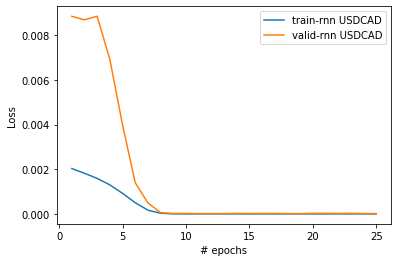

Start training
Training complete in 1m 18s


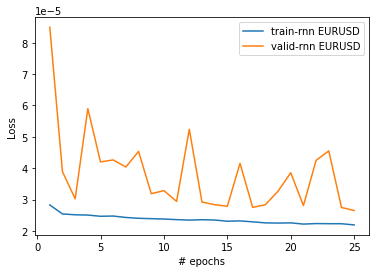

Start training
Training complete in 1m 18s


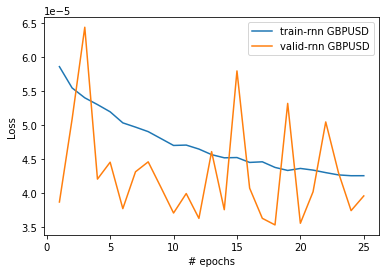

Start training
Training complete in 1m 17s


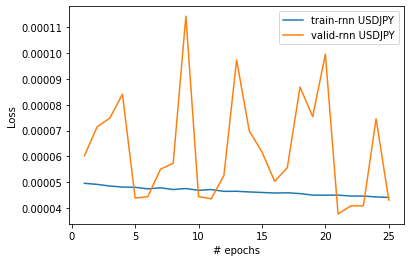

Start training
Training complete in 1m 17s


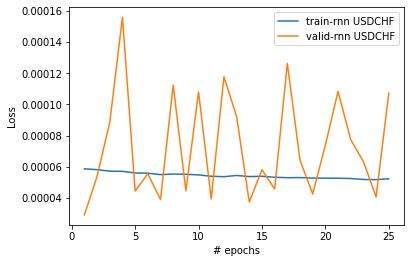

Start training
Training complete in 1m 18s


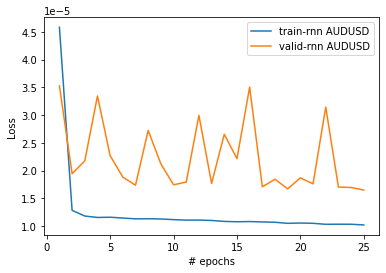

Start training
Training complete in 1m 17s


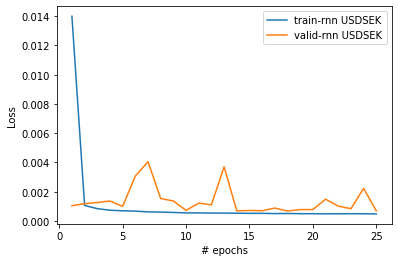

Start training
Training complete in 1m 17s


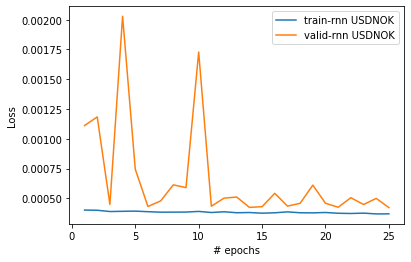

Start training
Training complete in 1m 17s


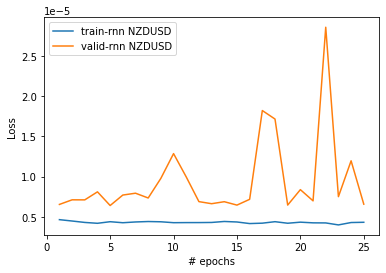

Start training
Training complete in 1m 17s


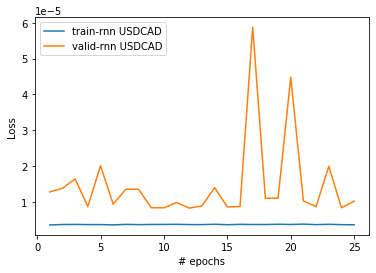

In [107]:
n_epoch = 25
batch_size = 4
seq_len = 8
pos_x = 7
pos_y = 8
taille_bloc_pred = pos_y - pos_x

# pre-training (initialement pas de pre-training)
model_rnn, rnn_weights  = get_rnn_instance()
                          #get_transformer_instance(input_dim = 1,
                                                   #output_dim = 1,n_layers = 2,
                                                   #hidden_size = 20,
                                                   #n_heads=1)
                          #get_lstm_instance(input_dim = 1,output_dim = 1,n_layers = 3,hidden_size = 60) 
                          #get_rnn_instance()

# Define the loss function
loss_fun = torch.nn.MSELoss()

# Perform training of the RNN model
optimizer_rnn = get_optimizer(model_rnn)

# choix parmi : ['USDCAD','EURUSD', 'GBPUSD','USDJPY','USDCHF','AUDUSD','USDSEK','USDNOK','NZDUSD','USDCAD']
for name_serie in ['USDCAD','EURUSD', 'GBPUSD','USDJPY','USDCHF','AUDUSD','USDSEK','USDNOK','NZDUSD','USDCAD']:
    data_train, data_val, data_test, stat = create_datasets(seq_len=seq_len, 
                                                            name_serie=name_serie,
                                                            pos_x=pos_x,
                                                            pos_y=pos_y,
                                                            mean=all_mean,
                                                            std=all_std)

    Xs_train,ys_train = data_train[0], data_train[1]
    Xs_validate,ys_validate = data_val[0], data_val[1]
    Xs_test,ys_test = data_test[0], data_test[1]

    train_loader, valid_loader, test_loader = create_dataloader(Xs_train, ys_train,
                                                                Xs_validate, ys_validate,Xs_test, 
                                                                ys_test,batch_size = batch_size)

    loss_history = train_model(model_rnn, rnn_weights, optimizer_rnn, loss_fun,
                               n_epoch=n_epoch,debug_flag=False)

    # Save loss history for later
    rnn_train_loss_history, rnn_valid_loss_history = loss_history

    # Save weights for later pre-training
    rnn_weights = copy.deepcopy(model_rnn.state_dict())

    # Plot training and validation curve

    xaxis = range(1, n_epoch + 1)
    plt.plot(xaxis, rnn_train_loss_history, label=f'train-rnn {name_serie}')
    plt.plot(xaxis, rnn_valid_loss_history, label=f'valid-rnn {name_serie}')

    plt.xlabel('# epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Validation pré-production du modèle (sur USDCAD)

In [116]:
# On recharge les données USDCAD car on veut tester les prédictions sur USDCAD

name_serie= 'USDCAD' #'USDCAD' #NZDUSD

data_train, data_val, data_test, stat = create_datasets(seq_len=seq_len, 
                                                        name_serie=name_serie,
                                                        pos_x=pos_x,
                                                        pos_y=pos_y,
                                                        mean=all_mean,
                                                        std=all_std)

Xs_train,ys_train = data_train[0], data_train[1]
Xs_validate,ys_validate = data_val[0], data_val[1]
Xs_test,ys_test = data_test[0], data_test[1]
mean, std = stat[0], stat[1]

In [109]:
def print_mean_abs_error(X, Y, idx=None):
    xs = X.numpy()
    ys = Y.numpy()

    if idx == None:
      diff = abs(xs-ys)
      print(f"Absolute mean error between target[:] et prediction[:] = {np.mean(diff)}")
    else:
      diff = abs(xs[idx]-ys[idx])
      print(f"Absolute mean error between target[{idx}] et prediction[{idx}] = {np.mean(diff)}")

## Validation avec le dataset de tests au complet

The RNN's test mean squared error is 0.000


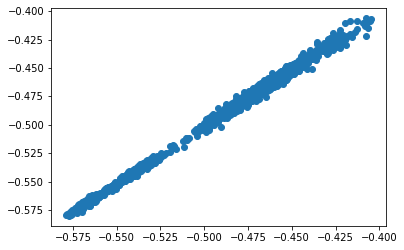

In [117]:
# Put sequence data on device (GPU when available)
Xs_test = Xs_test.to(device)

# Put target data on device (GPU when available)
ys_test = ys_test.to(device)

# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(Xs_test)

# Compute the loss of the RNN-based model using the loss function
loss_test_rnn = loss_fun(ypred_rnn, ys_test)

print(f"The RNN's test mean squared error is {float(loss_test_rnn):2.3f}")

plt.scatter(ys_test.cpu().detach().numpy(),ypred_rnn.cpu().detach().numpy())

## Validation avec des séquences unitaires

Dans la section suivante on affiche une prédiction de prix.

On affiche la prévision pour l'un des éléments du jeu de test (en fixant idx). 

In [118]:
idx = 0

# Put sequence data on device (GPU when available)
Xs_unit = Xs_test[idx:idx+1,:,:].to(device)

# Put target data on device (GPU when available)
ys_unit = ys_test[idx].to(device)

# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(Xs_unit)

Xs_unit = Xs_unit.cpu()
ypred_rnn = ypred_rnn.cpu()
ys_unit = ys_unit.cpu()

# Unstandardize  xtest ytest
xunit_unstd = Xs_unit*std + mean

ys_unit_unstd = ys_unit*std + mean

# Unstandardize  the predictions of the RNN-based model on xtest
ypred_unstd = ypred_rnn*std + mean

print(f"xunit[{idx}] = {xunit_unstd.detach()[0,:,0]}")
print(f"ys_unit[{idx}] = {ys_unit_unstd.detach()}\n ypred[{idx}] = {ypred_unstd.detach()}")

print_mean_abs_error(ys_unit_unstd.detach(), ypred_unstd.detach())

xunit[0] = tensor([1.0232, 1.0213, 1.0160, 1.0160, 1.0162, 1.0174, 1.0168])
ys_unit[0] = tensor([1.0148])
 ypred[0] = tensor([[1.0131]])
Absolute mean error between target[:] et prediction[:] = 0.0016167163848876953


## Prédiction sur n blocs suivants

> La fonction suivante permet de réaliser le bootstrapping évoqué en introduction. Aujourd'hui (le 30 mai 2021), je ne pense pas que ce soit une bonne idée. Je laisse la fonction pour mémoire mais elle n'est plus utilisée (**bootstrap == False** dans les appels)

In [112]:
def shif_right_and_complete(input_seq, item_to_add, debug=False,pos_x=7):
  if debug == True:
    print(input_seq[0,:,0])
    print(item_to_add[0])
    print("--------------------")
  output = input_seq[:,1:pos_x,:]
  output = torch.cat((output, item_to_add.unsqueeze(2)),dim=1)
  if debug == True:
    print(output[0,:,0])
  return output

In [113]:
def prediction_n_blocs(inputs, targets, mean, std, n=7, idx=1500, display=False, 
                       bootstrap=True, seq_len=7,taille_bloc_pred=1):
  Xs_unit = inputs[idx:idx+1,:,:]
  ys_targets = np.array([])
  ys_predicts = np.array([])
  ys_model1 = np.ones(n)*targets.numpy()[idx-1]
  ys_model2 = np.ones(n)*torch.mean(inputs[idx-1:idx,:,:]).numpy()

  for i in range(idx,idx+n):
    Xs_unit = Xs_unit.to(device)
    ypred_rnn = model_rnn(Xs_unit)
    ys_targets = np.append(ys_targets,targets.numpy()[i])
    ys_predicts = np.append(ys_predicts, ypred_rnn.cpu().detach().numpy()[0])
    if bootstrap == True:
      Xs_unit = shif_right_and_complete(Xs_unit.detach(), ypred_rnn.detach())

  y_targets = ys_targets*std + mean
  y_predicts = ys_predicts*std + mean
  y_model1 =  ys_model1*std + mean
  y_model2 =  ys_model2*std + mean

  y_previous = targets.numpy()[idx-seq_len:idx,0]*std + mean

  rnn_mse = np.mean(np.power((y_predicts - y_targets),2))
  model1_mse = np.mean(np.power((y_model1 - y_targets),2))
  model2_mse = np.mean(np.power((y_model2 - y_targets),2))

  # prediction sur le sens de la tendance (haussière ou baissière)
  # dans les cas des 2 modèles standards, ce n'est pas possible
  target_direction = np.sign(y_targets[-1] - y_previous[-1])
  predict_direction = np.sign(y_predicts[-1] - y_previous[-1])

  if display == True:
    xaxis = range(1, seq_len+1)
    plt.plot(xaxis, y_previous, label=f'past {seq_len} days')

    start = seq_len+taille_bloc_pred
    xaxis_pred = range(start, start+(n)*taille_bloc_pred,taille_bloc_pred)
    plt.plot(xaxis_pred, y_targets, label='targets (real)')
    plt.plot(xaxis_pred, y_predicts, label=f'RNN (mse={rnn_mse})')
    plt.plot(xaxis_pred, y_model1, label=f'Std model1 (mse={model1_mse})')
    plt.plot(xaxis_pred, y_model2, label=f'Std model2 (mse={model2_mse})')

    plt.xlabel('# jours')
    plt.ylabel('Fx Price')
    plt.title(f'Predictions idx={idx}')
    plt.legend()

    plt.show()
  
  return rnn_mse, model1_mse, model2_mse, (predict_direction == target_direction)

### Quelques courbes et résultats pour les prédictions sur n jours

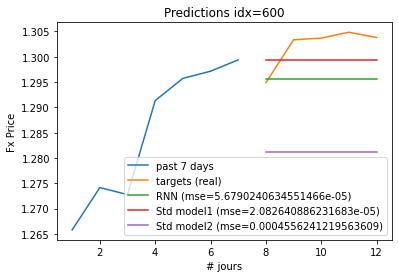

prediction tendance correcte? False


In [119]:
# attention idx doit être > seq_len
_,_,_,trend = prediction_n_blocs(Xs_test.cpu(), ys_test.cpu(), mean, std, n=5, idx=600, display=True,
                   bootstrap=False, seq_len=pos_x, taille_bloc_pred=taille_bloc_pred)
print(f"prediction tendance correcte? {trend}")

### Évaluation de la performance du modèle RNN par rapport à la marche aléatoire

In [122]:
rnn_mse_all = np.array([])
rnn_direction_all = np.array([])
model1_mse_all = np.array([])
model2_mse_all = np.array([])

X = Xs_test.cpu()
Y = ys_test.cpu()
n = 1
display = False
bootstrap = False

for idx in range(seq_len+1,X.shape[0]-n):
  r_mse, m1_mse, m2_mse, dir = prediction_n_blocs(X, Y, mean, std, n=n, idx=idx, display=display, 
                                                  bootstrap=bootstrap, seq_len=seq_len,
                                                  taille_bloc_pred=taille_bloc_pred)
  rnn_mse_all = np.append(rnn_mse_all,r_mse)
  rnn_direction_all = np.append(rnn_direction_all, dir)
  model1_mse_all = np.append(model1_mse_all,m1_mse)
  model2_mse_all = np.append(model2_mse_all,m2_mse)

rnn_mse_all = rnn_mse_all[~np.isnan(rnn_mse_all)]
model1_mse_all = model1_mse_all[~np.isnan(model1_mse_all)]
model2_mse_all = model2_mse_all[~np.isnan(model2_mse_all)]

print(f'   mean rnn MSE = {np.mean(rnn_mse_all)}')
print(f'mean model1 MSE = {np.mean(model1_mse_all)}')
print(f'mean model2 MSE = {np.mean(model2_mse_all)}')
print(f'rnn direction predict accuracy = {np.sum(rnn_direction_all)/np.size(rnn_direction_all)}')

   mean rnn MSE = 5.227946129347788e-05
mean model1 MSE = 3.557092519608108e-05
mean model2 MSE = 0.00013569357630211228
rnn direction predict accuracy = 0.4829222011385199


# Conclusion

J'ai réalisé plusieurs tests des modèles RNN, LSTM et Transformer pour la prédiction des prix des devises. Pour les prévisions sur 1 jour seulement comme pour celles sur 7 jours, le RNN, tout comme le LSTM, ne bat pas le modèle de marche aléatoire. 

Concernant l'apprentissage, j'ai entraîné le RNN, le LSTM et le Transformer avec 1 devise, puis 2, 3 et jusqu'à 9 devises (en sauvegardant les poids internes). Ils ont appris successivement sur toutes les devises. Malgré l'apport de plusieurs devises, le RNN, le LSTM et le Transformer ne battent pas la marche aléatoire mais on constate qu'ils s'en rapprochent de plus en plus en terme d'erreur.

Pourrait-on dire alors que plus on lui apprend avec de nouvelles devises ... plus il "comprend" que la marche aléatoire est la meilleure prévision? Ce point reste à clarifier.

J'ai aussi vérifié combien de fois il prédisait la bonne tendance (hausse ou baisse) ... et on est à 50% en moyenne, ce qui semble confirmer que la marche aléatoire est asymptotiquement la conclusion de son apprentissage.

Les modèles LSTM (**Long-Short Term Memory**) et **Transformer** sont utiles lorsque l'on traite de longues séquences (20 termes et plus) et mettent en œuvre le concept **"d'attention"** c'est à dire sur quels éléments de la séquence il faut porter attention pour prédire la suite (cas de la traduction automatique de texte). Pour des séquences de 7 termes, le RNN est suffisant. Ces modèles sont donc à considérer pour des séquences de 20, 30 ou 60 termes.

J'ai mené des tests avec le LSTM et le Transformer sur des séquences de 30 et 60 jours, ils ne battent toujours pas la marche aléatoire.